# Environment Detection for Self Driving Cars

## Computer Vision Final Project


### Submitted By:
#### Ayush Sethi(as11500) | Kunal Katdare(kpk309) | Srinath Chandrasekhar(sc6637) | Vatsal Shah(vds254)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os,glob
import warnings
warnings.filterwarnings("ignore")
from moviepy.editor import VideoFileClip
from collections import deque

In [262]:
test1 = mpimg.imread("speed_sign.jpg")

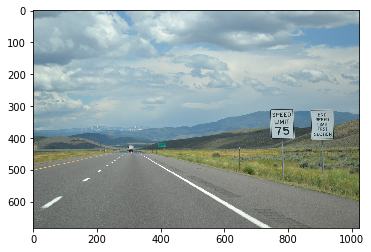

In [263]:
plt.imshow(test1)

# Lane Detection Algorithm

In [5]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def smoothing_filter(k):
    kernel = np.ones((k,k), np.float32)/(k*k)
    return kernel

def padding_func(img,kernel):
    row = int(kernel.shape[0]/2)
    column = int(kernel.shape[1]/2)
    padded_img = np.pad(img,((row, row),(column, column)),mode='constant')
    return padded_img

def smoothing(padded_image, image, kernel):
    m, n = kernel.shape  
    x, y = image.shape
    s,t = padded_image.shape
    new_image = np.zeros_like(image)
    for i in range(x):
        for j in range(y):
            sum = 0.0
            for p in range(m):
                for q in range(n):
                    sum = sum + (padded_image[i+p][j+q]*kernel[p][q])
            new_image[i][j] = sum
    return new_image

#we use a sobel operator for edge detection
def sobel(img, threshold, kernel):
    k = int(kernel/2)
    h,w = img.shape
    Gx = np.zeros((h,w))
    Gy = np.zeros((h,w))
    Tan = np.zeros((h,w))
    I=np.zeros((h,w))
    our_threshold=np.zeros((h,w))
    

    Gx_Filter=[[-1, 0, 1],[-2, 0, 2],[ -1, 0, 1]]
    Gy_Filter=[[-1, -2, -1],[0, 0, 0],[ 1, 2, 1]]

    for i in range(2,h-2):
        for j in range(2,w-2):
            block = img[i-k:i+k+1, j-k:j+k+1]
            res_gx = np.sum(np.multiply(block, Gx_Filter))
            res_gy = np.sum(np.multiply(block, Gy_Filter))
            intensity = math.sqrt(res_gx**2 + res_gy**2)
            Gx[i][j] = int(res_gx)
            Gy[i][j] = int(res_gy)
            Tan[i][j] = math.degrees(math.atan(res_gy/res_gx))
            I[i][j] = int(intensity)
            # I have set the threshold here
            if(I[i][j] > threshold):
                our_threshold[i][j] = 255
    return I, Gx, Gy, Tan, our_threshold

def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.02, rows*0.99]
    top_left     = [cols*0.04, rows*0.03]
    bottom_right = [cols*0.99, rows*0.99]
    top_right    = [cols*0.6, rows*0.6]
    print(bottom_left, top_left, bottom_right, top_right)
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

def getLength(startPoint,secondPoint):
    v1x=secondPoint[0]-startPoint[0]
    v1y=secondPoint[1]-startPoint[1]
    lenv=np.sqrt(v1x*v1x+v1y*v1y)
    return lenv


In [7]:
def hough_transform(img_bin, theta_res=1, rho_res=1, thresholdVotes=60, filterMultiple=30, thresholdPixels=0):
    nR,nC = img_bin.shape
    #print("Image shape is :" , nR, nC)
    theta = np.linspace(-90.0, 0.0, np.ceil(90.0/theta_res) + 1.0)
    theta = np.concatenate((theta, -theta[len(theta)-2::-1]))
    #print("Theta is :",theta)
    
    D = np.sqrt((nR - 1)**2 + (nC - 1)**2)
    #print("nR is: ",nR-1, " nC is : ",nC-1, "and D is :", D)
    
    q = np.ceil(D/rho_res)
    #print("Q is :",q)
    
    nrho = 2*q + 1
    #print("nrho(2Q+1) is :", nrho)
    
    rho = np.linspace(-q*rho_res, q*rho_res, nrho)
    #print("Rho is :",rho)
    
    #print("Len of rho is :",len(rho)," and Len of Theta is : ", len(theta))
    H = np.zeros((len(rho), len(theta)))
    print(H.shape)
    for rowIdx in range(nR):
        for colIdx in range(nC): 
            if img_bin[rowIdx, colIdx]:
                for thIdx in range(len(theta)):
                    rhoVal = colIdx*np.cos(theta[thIdx]*np.pi/180.0) + \
                      rowIdx*np.sin(theta[thIdx]*np.pi/180)
                    #print("Rho - RhoVal is :",rho - rhoVal)
                    rhoIdx = np.nonzero(np.abs(rho-rhoVal) == np.min(np.abs(rho-rhoVal)))[0]
                    #print(rhoIdx[0])
                    H[rhoIdx[0], thIdx] += 1
                    
    if filterMultiple>0:
        clusterDiameter=filterMultiple
        values=np.transpose(np.array(np.nonzero(H>thresholdVotes)))
        filterArray=[]
        filterArray.append(0)
        totalArray=[]
        for i in range (0, len(values)):
            if i in filterArray[1::]:
                continue
            tempArray=[i]
            for j in range (i+1, len(values)):
                if j in filterArray[1::]:
                    continue
                for k in range (0, len(tempArray)):
                    if getLength(values[tempArray[k]],values[j])<clusterDiameter:
                        filterArray.append(j)
                        tempArray.append(j)
                        break
            totalArray.append(tempArray)
        
        #leave the highest value in each cluster
        for i in range (0, len(totalArray)):
             for j in range (0, len(totalArray[i])):
                if j==0:
                    highest=H[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]
                    ii=i
                    jj=j
                else:
                    if H[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]>=highest:
                        highest=H[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]
                        H[values[totalArray[ii][jj]][0],values[totalArray[ii][jj]][1]]=0
                        ii=i
                        jj=j
                    else:
                        H[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]=0
                    
    return H, (np.where(H>thresholdVotes)[0]-q)*rho_res, theta[np.where(H>thresholdVotes)[1]]*np.pi/180.0
    #return rho, theta, H, q
    

def plotHoughPointLines(rho,theta,image):
    region_limit = image.shape[0]*0.7
    for i in range(len(theta)):
            theta_val = theta[i]
            rho_val = rho[i]
            cos_theta = math.cos((theta_val))
            sin_theta = math.sin((theta_val))
            y = []
            for x in range(0,image.shape[1]):
                y_ele = (int)((rho_val - (x*(sin_theta))) / (cos_theta))
                y.append(y_ele)
            for x in range(image.shape[1]):
                if x > region_limit:
                    cv2.line(image, (y[x],x),(y[x],x), (255,0,0),5)

In [6]:
def process(image):
        white_yellow = select_white_yellow(image)
        gray         = convert_gray_scale(white_yellow)
        smoothing_kernel = smoothing_filter(7)
        padded_img = padding_func(gray, smoothing_kernel)  
        smoothed_img = smoothing(padded_img, gray, smoothing_kernel)
        a, b, c, d, e        = sobel(smoothed_img, 60, 3)
        regions      = select_region(e)
        H1, r1, t1 = hough_transform(regions)
        
        plotHoughPointLines(r1, t1, image) 
        return image

[20.48, 676.17] [40.96, 20.49] [1013.76, 676.17] [614.4, 409.8]
(2461, 181)
(683, 1024, 3)


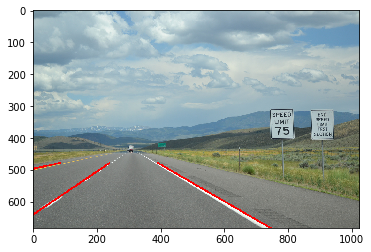

In [268]:
lane_detected = process(test1)
plt.imshow(lane_detected)
print(lane_detected.shape)

## Speed Limit Sign Detection

In [8]:
def read_image(img_name):
    image = mpimg.imread(img_name)
    color_image = image
    image = image[:,:,1]
    return image,color_image
    

def read_template(template_name):
    img = (mpimg.imread(template_name))
    img = img[:,:,1]
    m, n = (img.shape)
    return img,m,n

def select_region_image(img):
    a, b = img.shape[:2]
    
    p = int(a*0.25)
    q = int(a*0.75)
    r = int(b*0.7)
    s = int(b*0.95)
    img = img[p:q, r:s]
    return img,p,r

def select_region_template(temp):
    m, n = temp.shape[:2]
    a = int(m*0.03)
    b = int(m*0.35)
    c = int(n*0.10)
    d = int(n*0.90)
    temp = temp[a:b, c:d]
    return temp

def padding(img, k):
    m,n = k.shape
    x= int(m/2)
    y = int(n/2)
    img = np.pad(img,((x,x),(y,y)),'constant')
    return img

def matching(img,k):
    filt_image = np.zeros_like(img).astype(float)
    #to pad the image
    pad_image = padding(img,k)
    a, b = img.shape
    m,n = k.shape
    for i in range(a):
        for j in range(b):
            sum = 0.0
            mean = 0.0
            mean_sum = 0.0
        
            #Applying convolution        
            for p in range(m):
                for q in range(n):
                    sum = sum + ((pad_image[i+p][j+q])*(k[p][q]))
            filt_image[i][j] = sum
    return filt_image

def cal_mean(img):
    m,n=img.shape
    sum = 0.0
    for i in range(m):
        for j in range(n):
            sum = sum + img[i][j]
    mean = sum/(m*n)
    for i in range(m):
        for j in range(n):
            img[i][j] = img[i][j] - mean
    return img

def drawCircle(color_img,cropped_template,cord_y,cord_x):
    l,k = cropped_template.shape
    cv2.circle(color_img,(cord_y,cord_x), int(k/1.2), (0,255,0), 3)

In [ ]:
color_img = lane_detected.copy()
img = lane_detected.copy()
img = img[:,:,1]
template,m,n = read_template('speed_limit.png')
cropped_img,p,r = select_region_image(img)
cropped_template = select_region_template(template)


In [275]:
temp_mean_image = cal_mean(cropped_template)

In [278]:
matched_image = matching(cropped_img,temp_mean_image)

### Normalizing the matched image

In [288]:
test_matched_image = matched_image
m,n = test_matched_image.shape
x = np.min(test_matched_image)
y = np.max(test_matched_image)
for i in range(m):
    for j in range(n):
        test_matched_image[i][j] = (test_matched_image[i][j]-x)
y = np.max(test_matched_image)
for i in range(m):
    for j in range(n):
        test_matched_image[i][j] = (test_matched_image[i][j]/y)

### Thresholding on the normalized matched image

In [289]:
thresh_matched_image = test_matched_image
for i in range(m):
    for j in range(n):
        if(test_matched_image[i][j] < 0.8):
            thresh_matched_image[i][j] = 0
        else:
            thresh_matched_image[i][j] =1

### Mapping to image space

In [290]:
u,v = thresh_matched_image.shape
cord_x = 0
cord_y = 0
for i in range(u):
    for j in range(v):
        if(thresh_matched_image[i][j]==1):
            cord_x = i
            cord_y = j
cord_x = cord_x + p
cord_y = cord_y + r

### Drawing circle on the identified spot

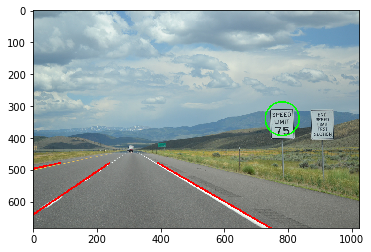

In [291]:
drawCircle(color_img,cropped_template,cord_y,cord_x)
plt.imshow(color_img)

### Testing above system on Video

In [13]:
QUEUE_LENGTH=50

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process_frame(self, image):
        white_yellow = select_white_yellow(image)
        gray         = convert_gray_scale(white_yellow)
        smoothing_kernel = smoothing_filter(7)
        padded_video = padding_func(gray, smoothing_kernel)  
        smoothed_video = smoothing(padded_video, gray, smoothing_kernel)
        a, b, c, d, e        = sobel(smoothed_video, 60, 3)
        regions      = select_region(e)
        H1, r1, t1 = hough_transform(regions)
        plotHoughPointLines(r1, t1, image) 
        return image

In [14]:
def process_video(video_input, video_output):
    detector = LaneDetector()
    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process_frame)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)

In [ ]:
process_video('test1.mp4', 'cv_project_output5.mp4')